## Similar images retrieval
Given an image X and another set of images, this program will retrieve out of this set the
K most colour-similar images to X.
In order to demonstrate my algorithm I' m using the Pokemon Kaggle dataset.

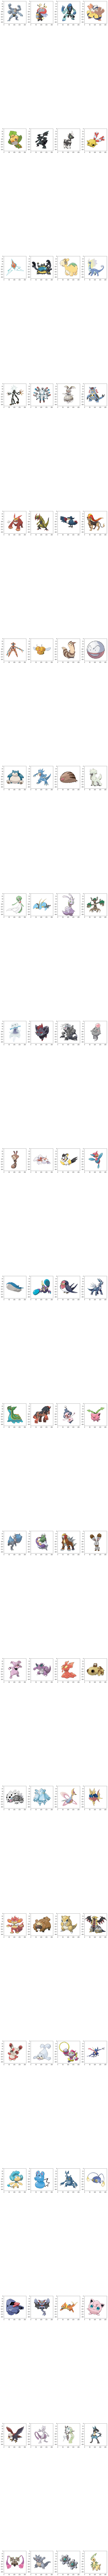

In [667]:
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display
from PIL import Image
from os.path import isfile, join
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN
from scipy.spatial import distance
import os as os
import itertools
import random
import heapq
import math
import csv
import re

m_clusters=4
path = 'POKEMON/'
pokemons = [(path + f) for f in os.listdir(path) if isfile(join(path, f))]
# # print(len(pokemons))
display_size=len(pokemons)//2
rows = display_size//4 + 1
_, axs = plt.subplots(rows, 4, figsize=(16, 425))
axs = axs.flatten()

# Display half of the pokemon dataset
for pokemon, ax in zip(pokemons[:], axs):
    im = Image.open(pokemon)
    ax.imshow(im)
    # print(im.format, im.size, im.mode)


#### Algorithm Description

For every pokemon image we are retrieving its M most frequent colours by performing a clustering procedure (DBSCAN) on its pixels. Then, M number of clusters will be created each one of them corresponding to a most frequent colour. 

We are giving DBSCAN a small radius-value and a big number of components per cluster so that it finds very small, compact clusters representing frequent colours. All the rest points-colours are considered to be noise. We take the core-components returned by DBSCAN for each cluster and we define their mean value as the representatives of those clusters.
From now on, we are using those representatives to "represent" the image.
We create (once) a new .csv file named "pokemon4.csv" which contains all of the new 'representations' of the images.


The following block contains some 'utility' code that will be used for the overall task!

In [664]:
#------------  Utilities ------------#

def remove_alpha_channel(im):
    im.load()
    rgb_image = Image.new("RGB", im.size, (255, 255, 255))
    rgb_image.paste(im, mask=im.split()[3]) # 3 is the alpha channel
    #     display(rgb_image)
    #     rgb_image.save('foo.jpg', 'JPEG', quality=80)
    return rgb_image

def make_clustering(X):
    clustering = DBSCAN(eps=2, min_samples=50).fit(X)
    labels = clustering.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    unique_labels = set(labels)
    return clustering, labels, unique_labels, n_clusters, n_noise

# Using a custom heap
class MyHeap(object):
    def __init__(self, initial=None, key=lambda x:x[1]):
        self.key = key
        if initial:
            self._data = [(key(item), item) for item in initial]
            heapq.heapify(self._data)
        else:
            self._data = []

    def push(self, item):
        heapq.heappush(self._data, (self.key(item), item))

    def pop(self):
        return heapq.heappop(self._data)[1]

    def peek(self):
        return self._data[0]
    
    def print(self):
        for i in self._data:
            print(i)
    
    def size(self):
        return len(self._data)
    
    
def parse(x):
    return [int(x) for x in re.split(",\s", x[1:-1])  if x != ""]


def visualize_clustering(pxls, core_samples_mask, labels, unique_labels, m_clusters):
    fig = plt.figure(figsize=(20,15))
    ax = fig.add_subplot(111, projection='3d')
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = [0, 0, 0, 1]    # Black used for noise.
        else :
            class_member_mask = (labels == k)
            # Ycore = pxls[class_member_mask & core_samples_mask]
            # ax.plot(Ycore[:,0], Ycore[:,1], Ycore[:,2], 'o', markerfacecolor=tuple(col),
            # markeredgecolor='k', markersize=10)
            Y = pxls[class_member_mask & ~core_samples_mask]
            ax.plot(Y[:,0], Y[:,1], Y[:,2], 'o', markerfacecolor=tuple(col), 
                    markeredgecolor='k', markersize=6)
    plt.show()


def top_M_colours(pxls, m_clusters, visualize=False):
    db, labels, unique_labels, db_clusters, _ = make_clustering(pxls)
    core_samples_mask = np.zeros_like(labels, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True

    hp = MyHeap()
    for k in unique_labels:
        if k != -1:
            class_member_mask = (labels == k)
            Ycore = pxls[class_member_mask & core_samples_mask]
            Y = pxls[class_member_mask & ~core_samples_mask]
            coreMean = np.mean(Ycore, axis=0)
            coreMean = [np.int(i) for i in coreMean]

            if k < m_clusters:
                hp.push([coreMean, Y.shape[0]])
            else:
                if hp.peek()[0] < Y.shape[0]:
                    hp.pop()
                    hp.push([coreMean, Y.shape[0]])
    # hp.print()
    size = min(m_clusters, hp.size())
    # print(size)
    x = [hp.pop() for i in range(size)]
    size = m_clusters - size
    if size > 0:   # Image did not have that many dominant colours
        for i in range(size):
            x.append(x[i])
    
    cores = [ a[0] for a in x]
    densities = [ a[1] for a in x]
    
    if visualize:
        visualize_clustering(pxls, core_samples_mask, labels, unique_labels, m_clusters)
    return cores,densities


# Computes the minimum distance between two images
def compute_distance(a, b, r):
    densitiesA = a[-1] ; a = a[:m_clusters]
    densitiesB = b[-1] ; b = b[:m_clusters]

    permutations = list(itertools.permutations(b))
    min_distance = np.mean([distance.euclidean(xi,yi) 
                           for (xi, yi) in zip(a, np.array(permutations[0]))])
    for i in range(1, len(permutations)):
        d = np.mean([distance.euclidean(xi,yi) 
                           for (xi, yi) in zip(a, np.array(permutations[i]))])
        if d < min_distance:
            min_distance = d
    return min_distance



#### Removing all the white pixels - Transforming RGBA to RGB
( It's implemented naively and it's costly! )

In [527]:
d =	dict()
for pokemon in pokemons:
    im = Image.open(pokemon)
    im = remove_alpha_channel(im)
    pixels = np.array(im.getdata(), dtype=np.uint8)
    indices = [i for (i,v) in enumerate(pixels) if v[0]==255 and v[1]==255 and v[2]==255]
    pixels = np.delete(pixels, indices, 0)
    d[pokemon] = pixels


The following block creats the new .csv file in which the representatives of the images get stored. 

Once that happens, it does not need to be re-executed ever again!
If the "pokemon4.csv" file does not exist in the project folder this code needs to be executed in order to create it.


In [529]:

# with open('pokemon4.csv', 'w') as csv_file:
#     fieldnames = ['image', 'A', 'B', 'C', 'D', 'Densities']
#     writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
#     writer.writeheader()
    
#     for p in pokemons:
#         pxls = d[p]
#         x,densities = top_M_colours(pxls, m_clusters)
# #         print(p,x, densities)
#         writer.writerow({'image': p, 'A': x[0], 'B': x[1], 'C': x[2], 
#                          'D': x[3], 'Densities': densities}) 


#### Visualization of Clusterings
Below, we can depict the clustering that is produced from the images of some given pokemons


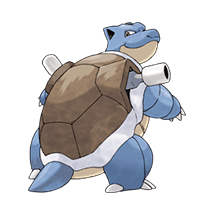

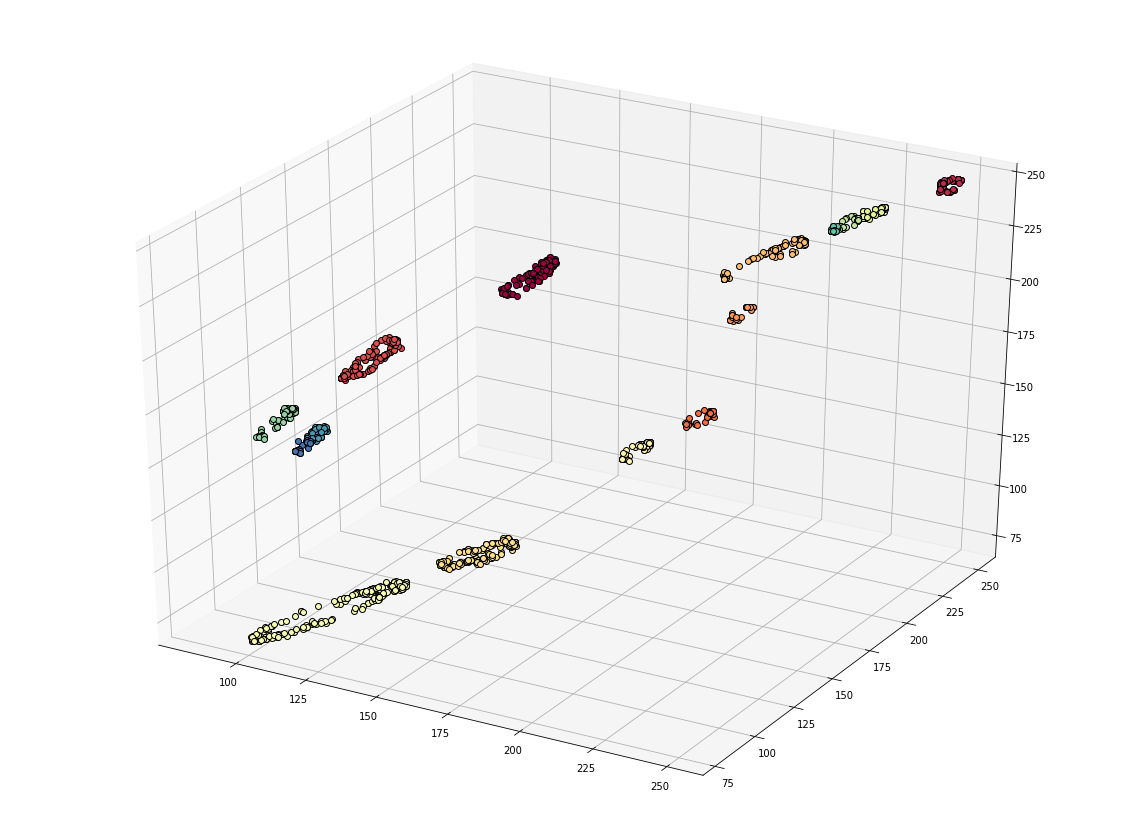

Representatives of M most frequent colours:  [[142, 170, 208], [108, 138, 178], [152, 126, 103], [114, 93, 79]]


<Figure size 1440x1080 with 0 Axes>

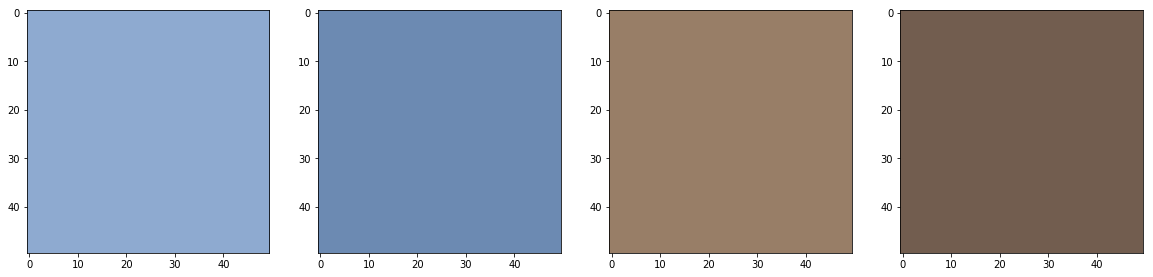

In [653]:

plist = ["POKEMON/0009.png"]

for p in plist:
    pxls = d[p]
    
    # Visualize the clusterings
    im = Image.open(p)
    display(im)
    topM, _ = top_M_colours(pxls, m_clusters, visualize=True)
    print("Representatives of M most frequent colours: ", topM)
    topM = np.array(topM)
    
#     # Print and Visualize only the Representatives
#     fig1 = plt.figure(figsize=(20,15))
#     ax = fig1.add_subplot(111, projection='3d')
#     ax.plot(topM[:,0], topM[:,1], topM[:,2], 'o', markerfacecolor='b', 
#             markeredgecolor='k', markersize=6)
#     plt.show()

    # Print the m-most frequent pixels
    fig2 = plt.figure(figsize=(20,15))
    _, axs1 = plt.subplots(1, m_clusters, figsize=(20, 15))
    axs1 = axs1.flatten()
    for x, ax1 in zip(topM, axs1):
        x = np.array(x, dtype=np.uint8)
        img = Image.fromarray(np.array([[x for i in range(50)] for i in range(50)]))
        ax1.imshow(img)
    plt.show()
    

### Retrieve K most similar Images

Now, for a given image specified by its file-name (e.g. "0001.png") we compute all the eucledian distances between that image and the rest of them (based on their new representations), and then print the images corresponding to the K smallest distances.

In [655]:

def retrieve_similar_images(pokemon_str, k):
    with open('pokemon4.csv', 'r') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        next(csv_reader, None)  # skip the headers

        pokemons1 = []
        for row in csv_reader:
            if row[0] == pokemon_str:
                pokemon = [parse(row[i]) for i in range(1,m_clusters+2)]
            else:
                pokemons1.append(row)

        myHeap = MyHeap()  
        for row in pokemons1:
            p = [parse(row[i]) for i in range(1,m_clusters+2)]
            Distance = compute_distance(pokemon, p, row[0])
            myHeap.push([row[0], Distance])

        # Retrieve the K most similar images
        similar_K = [myHeap.pop() for i in range(k)]
        im = Image.open(pokemon_str)
        display(im)

        rows = math.ceil(k/4) + (k<4)
        _, axs = plt.subplots(rows, 4, figsize=(25, rows*6))
        axs = axs.flatten()

        for i, x in enumerate(similar_K):
            # print(x[0], ", Distance between Images: ", x[1])
            im = Image.open(x[0])
            axs[i].imshow(im)
            

#### Some Testing...

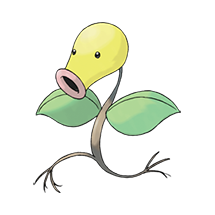

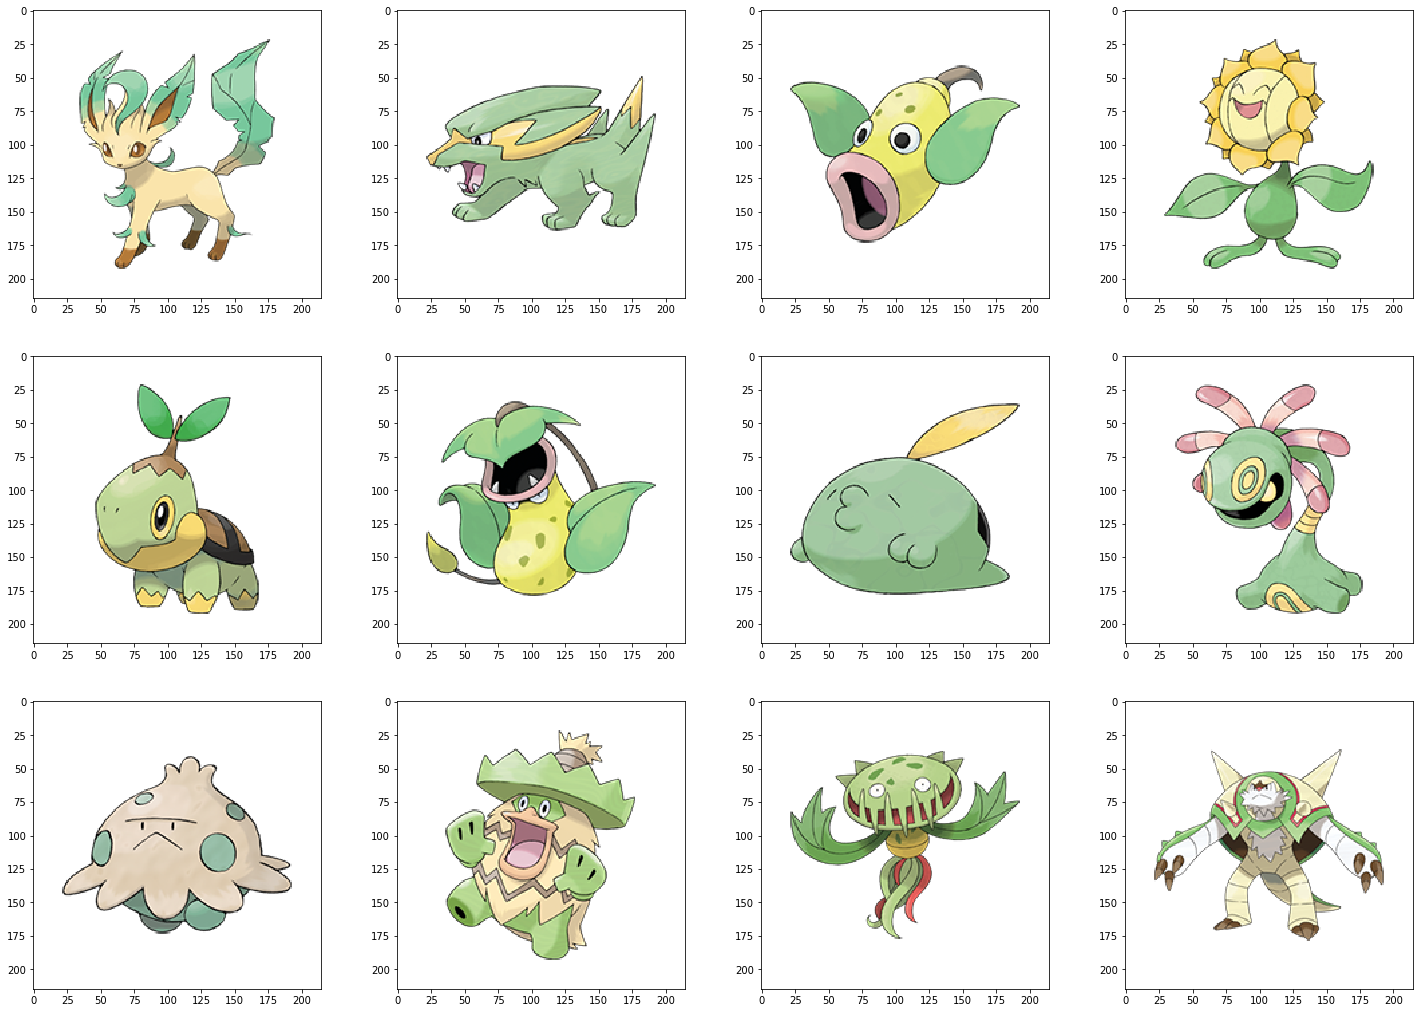

In [656]:
# Define K and the Input Image
k = 12 ; pokemon_str = path + "0069.png"
retrieve_similar_images(pokemon_str, k)

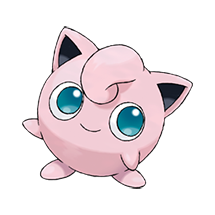

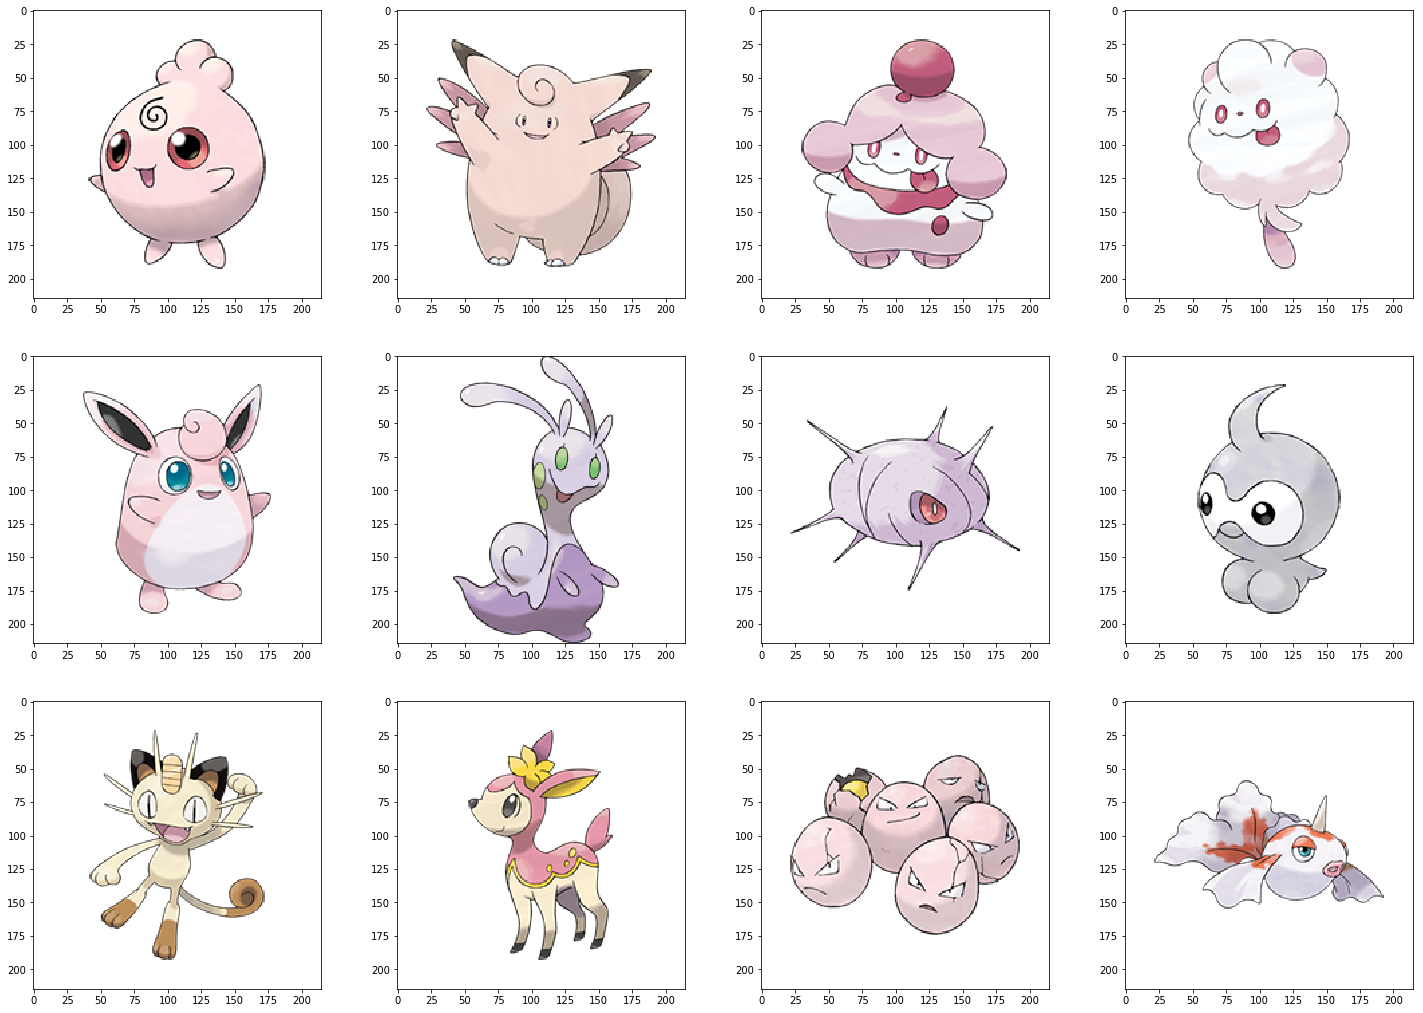

In [657]:
# Define K and the Input Image
k = 12 ; pokemon_str = path + "0039.png" 
retrieve_similar_images(pokemon_str, k)

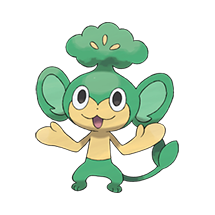

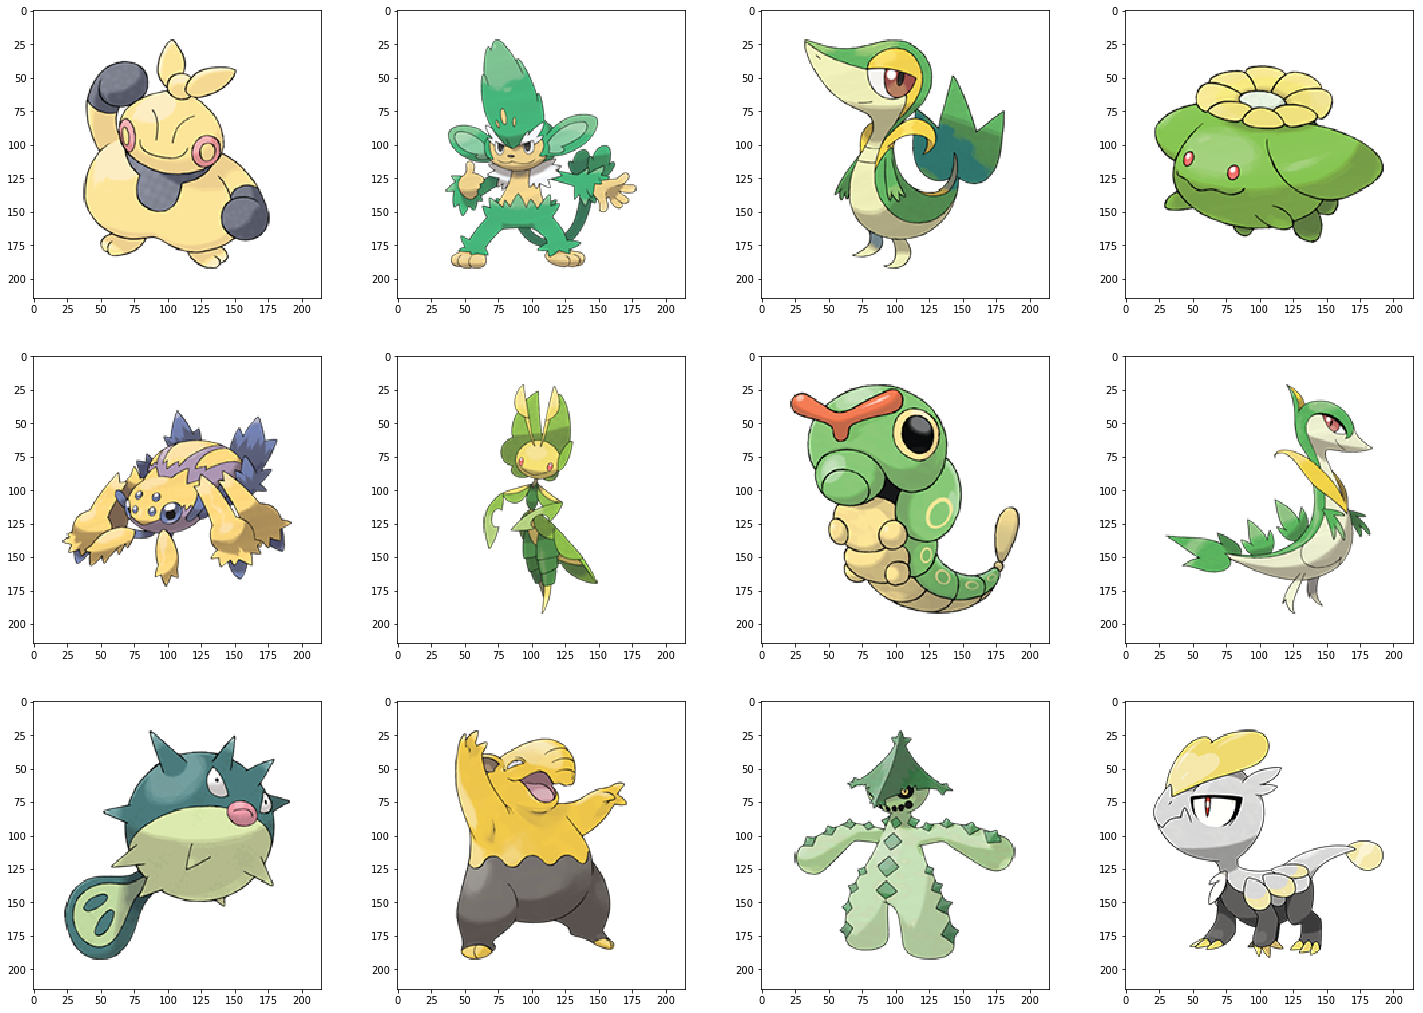

In [658]:
# Define K and the Input Image
k = 12 ; pokemon_str = path + "0511.png" 
retrieve_similar_images(pokemon_str, k)

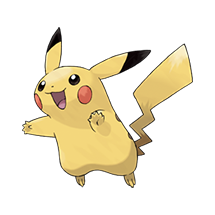

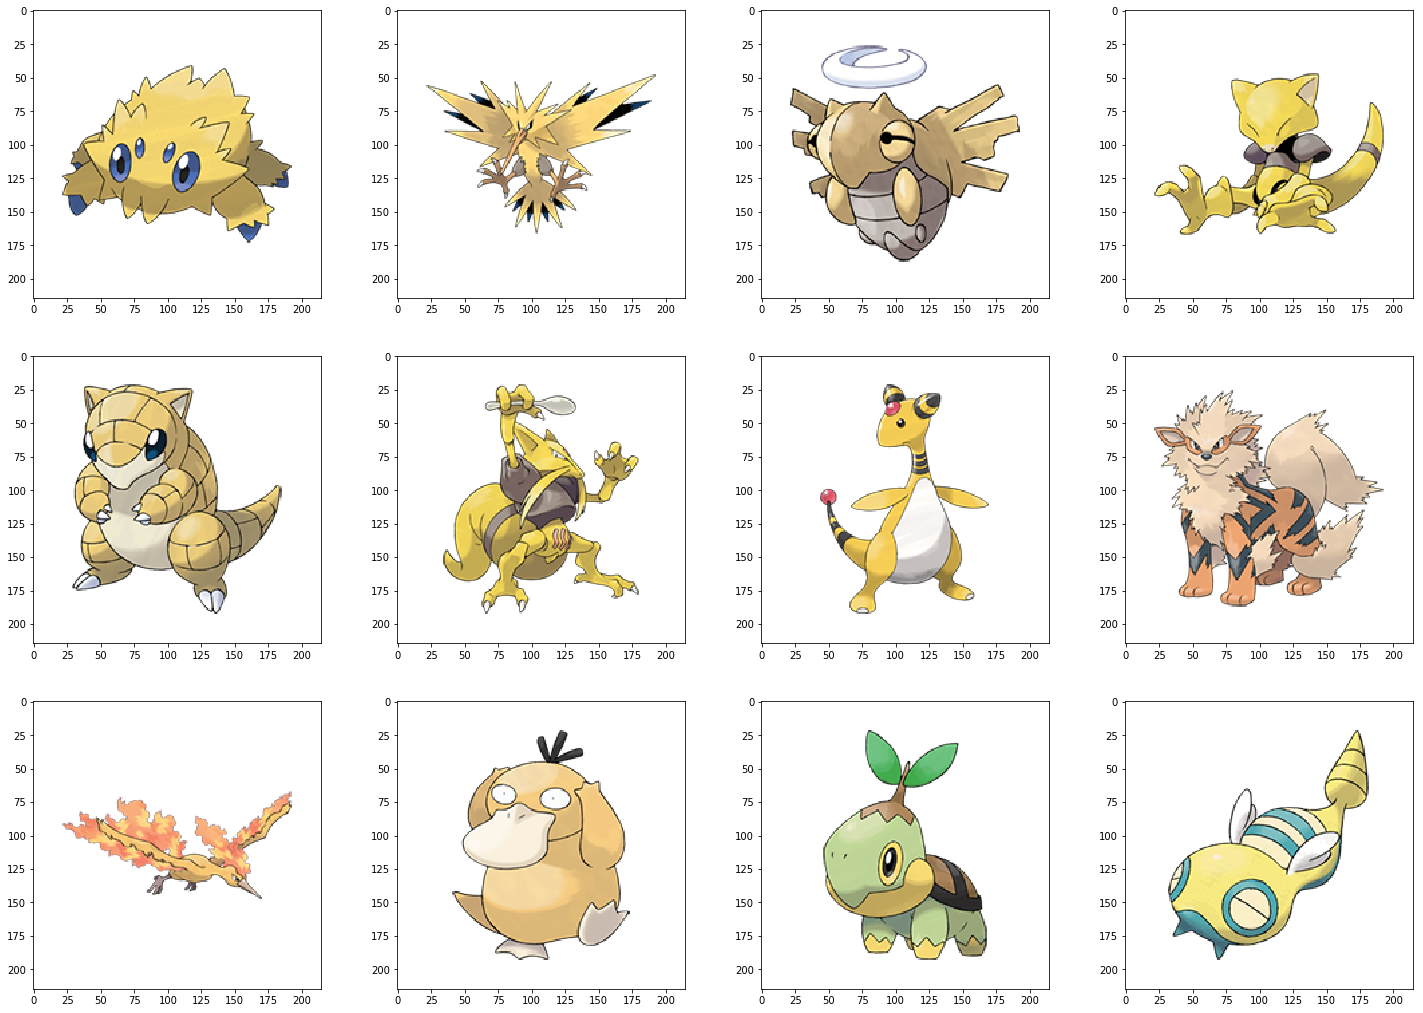

In [659]:
# Define K and the Input Image
k = 12 ; pokemon_str = path + "0025.png" 
retrieve_similar_images(pokemon_str, k)

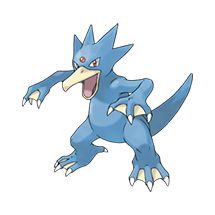

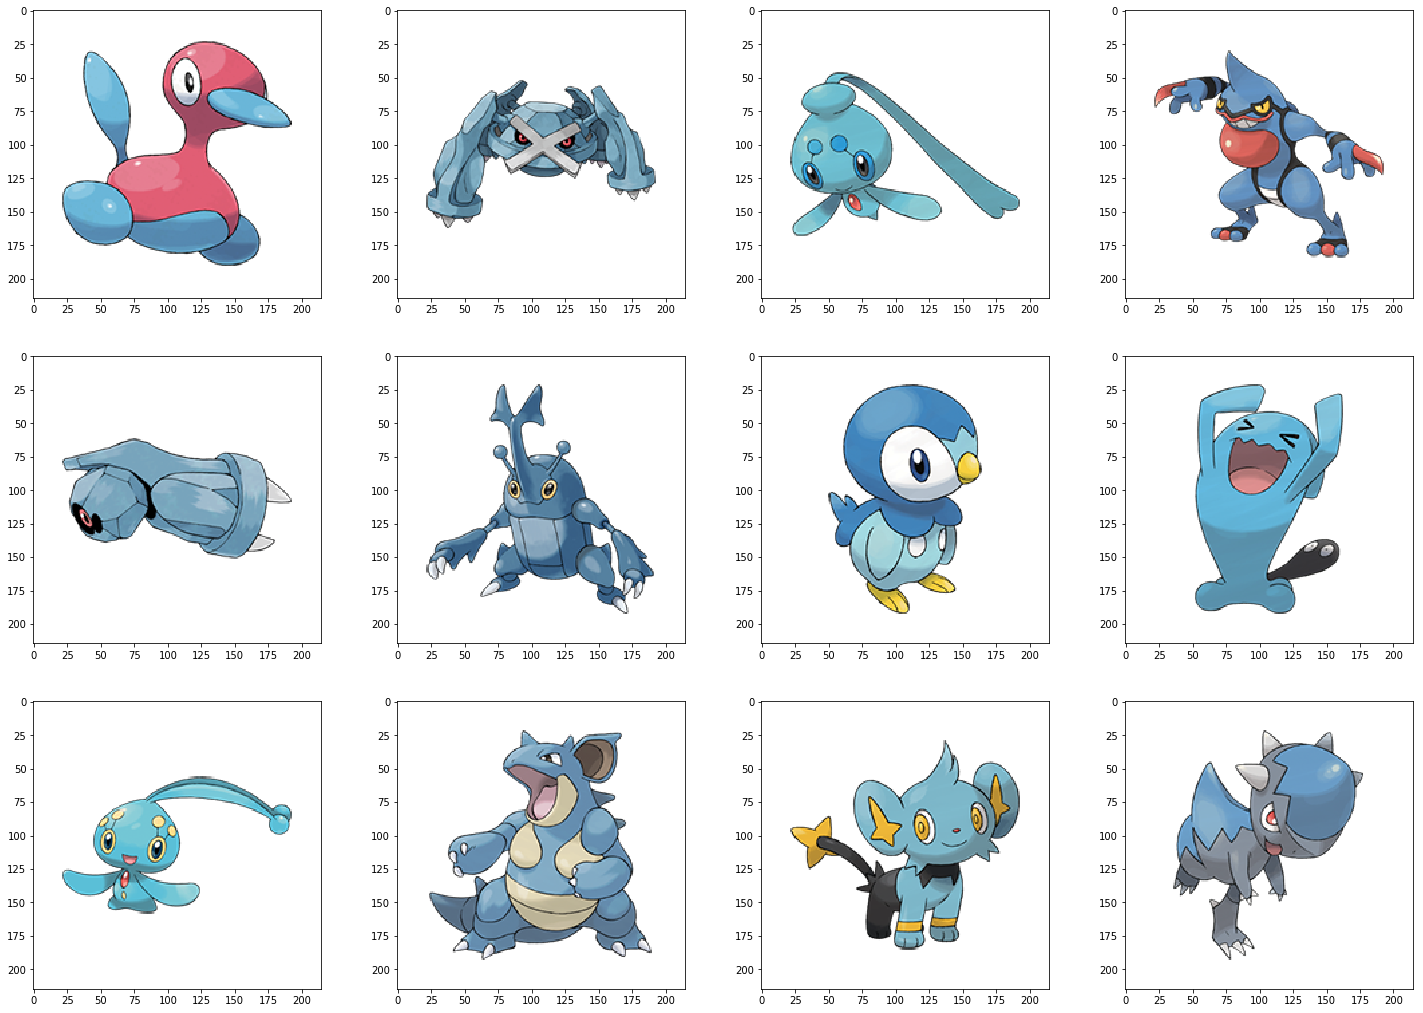

In [660]:
# Define K and the Input Image
k = 12 ; pokemon_str = path + "0055.png" 
retrieve_similar_images(pokemon_str, k)

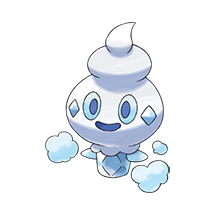

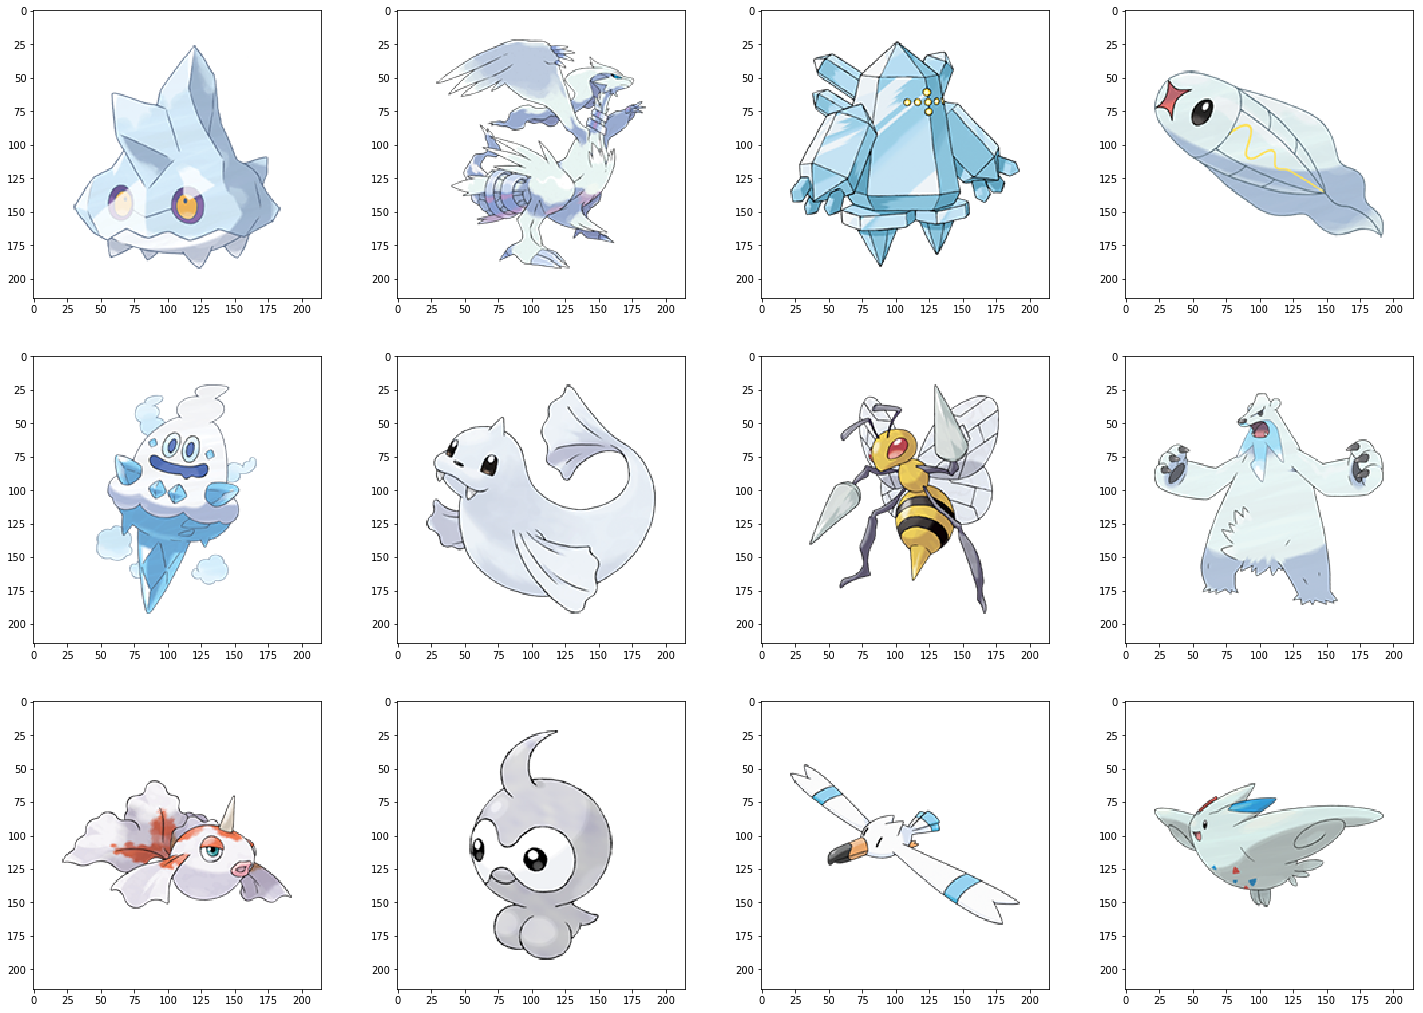

In [662]:
# Define K and the Input Image
k = 12 ; pokemon_str = path + "0582.png" 
retrieve_similar_images(pokemon_str, k)